# Feature Selection

**Why feature selection?** Feature selection is the process of identifying and selecting the most important features (aka variables) in a dataset to improve model performance. By removing irrelevant features, it can reduce overfitting, speed up training, and enhance model interpretability.

**In comes in XGBoost!** XGBoost is great for feature selection because it automatically evaluates the importance of each feature based on how much it improves the model's predictions. It does this by looking at how often each feature is used in decision trees and how much it contributes to reducing errors. This makes it easy to identify and keep the most important features while discarding irrelevant ones, leading to a simpler and more efficient model.

##### **Pros and Cons of Feature Selection with XGBoost**
| **Pros**                           | **Cons**                                      |
|-------------------------------------|-----------------------------------------------|
| **Built-in Feature Importance**: XGBoost ranks features by importance (e.g., Gain, Weight). | **Bias in Importance**: XGBoost may favor frequently used or correlated features, even if not truly important. |
| **Reduces Overfitting**: By removing irrelevant features, it helps the model generalize better. | **Computational Overhead**: Feature selection methods may require additional model training and evaluation. |
| **Improves Efficiency**: Reduces training time and computation by selecting fewer features. | **Risk of Overfitting**: Poor feature selection may lead to overfitting if not validated properly. |
| **Automatic Ranking**: Features are ranked and selected based on their contribution to model performance. | **Limited Flexibility**: XGBoost’s feature importance may miss complex non-linear relationships. |
| **Works with Other Methods**: Can be combined with techniques like SelectKBest or RFE for better feature selection. | **Model-Specific**: Features selected by XGBoost may not work well with other algorithms. |
 
### What you'll find in this notebook:
1.  User created functions to easily call upon xgboost and interpret the performance of the model
    2.  roc_print: This function prints the ROC curves of both our test and training clssification models.
    3.  graph_xgb: This function graphs the top N features from our XGBoost model into a bar chart.
    4.  build_xgb:  This function returns a XGBoost model and a list of the top N features.
2.  Using the above functions.



In [82]:
#pip install xgboost

In [46]:
# packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn import metrics 
from sklearn.metrics import * #(roc_auc_score, confusion_matrix, accuracy
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [74]:
# XGBoost 
def roc_print(y_train, y_test, y_pred, y_pred_test):
    """
    This function prints the ROC curves of both our test and training clssification models.
    The # quantifies the model's ability to distinguish between the positive class and the negative class
    
    Args: 
        y_train (pd.Series): Label data used for training the model 
        y_test (pd.Series): Label data used for evaluating the model
        y_pred (np.ndarray): Predicted lables from Training data
        y_pred_test (np.ndarray): Predicted labels from Test data
        
    Returns: None
    """
    roc_train = roc_auc_score(y_train, y_pred)
    roc_test = roc_auc_score(y_test, y_pred_test)
    
    auc = roc_train
    if auc == 1:
        status = "The model perfectly classifies all positive and negative examples. It may be overfit"
    elif 0.6 < auc < 1:
        status = "The model has decent/good performance. The higher the AUC the better."
    elif 0.5 < auc <= 0.6:
        status = "The model is only slightly better than random guessing."
    else:
        status = "The model has quite poor performance, suggestion to retrain with more data or features."
    print("Train ROC:", roc_train, "\n", status)

    auc = roc_test
    if auc == 1:
        status = "The model perfectly classifies all positive and negative examples. It may be overfit"
    elif 0.6 < auc < 1:
        status = "The model has decent/good performance. The higher the AUC the better."
    elif 0.5 < auc <= 0.6:
        status = "The model is only slightly better than random guessing."
    else:
        status = "The model has quite poor performance, suggestion to retrain with more data or features."
    print("Test ROC:", roc_test, "\n", status)
    
    return
 
def graph_xgb(cols, importance):
    """
    This function graphs the top N features from our XGBoost model into a bar chart.

    Args: 
        cols (list): list of top features to be graphed into a barchart
        importance (list): List of feature importances outputted from our model
    Returns: None
    """
    plt.rcdefaults()
    fig, ax = plt.subplots()

    y_vals = np.arange(len(cols))
    ax.barh(cols, importance)
    ax.set_yticks(y_vals)
    ax.invert_yaxis() # reading labels top to bottom
    ax.set_xlabel('F Score')
    ax.set_title('Top Features')

    plt.show()
    return


def build_xgb(x_train, y_train, x_test, y_test, n_feat, classify, roc=True):
    """
    This function returns a XGBoost model and a list of the top N features.

    Args:
        x_train (pd.DataFrame): Feature data used for training the model
        y_train (pd.Series): Label data used for training the model
        x_test (pd.DataFrame): Feature data used for evaluating the model
        y_test (pd.Series): Label data used for evaluating the model
        n_feat (int): Top N most important features from model
        classify (bool): Signified if y labels are classification or regression
        roc (bool): Determines if ROC scores will be printed
   
    Returns: 
        xgb_model: XGBoost Model
        cols: List of top N most important features based off of model
    """
    # edge case testing to ensure inputs are the right format
    if not isinstance(n_feat, int):
        print("Error! variable 'n_feat' should be an integer.")
        return 
        

    if len(x_train) <= len(x_test):
        print("Error! Check your x inputs. The training data is smaller than testing.")
        return

    if len(y_train) <= len(y_test):
        print("Error! Check your y inputs. The training data is smaller than testing.")
        return

    # categorical Y
    if classify == True:
        xgb = XGBClassifier(seed = 13)

    # continuos Y
    else:
        xgb = XGBRegressor(seed = 13)
        roc = False # can't use this for regression

    # build model
    xgb_model = xgb.fit(x_train, y_train)

    # make predictions - TRAIN
    y_pred = xgb_model.predict(x_train)
    predictions = [round(value) for value in y_pred]

    # print metrics - TRAIN
    accuracy = accuracy_score(y_train, predictions)
    print("Train Accuracy: %.2f%%" % (accuracy*100.0))
    
    # make predictions - TEST
    y_pred_test = xgb_model.predict(x_test)
    predictions_test = [round(value) for value in y_pred_test]

    # print metrics - TEST
    accuracy_test = accuracy_score(y_test, predictions_test)
    print("Test Accuracy: %.2f%%" % (accuracy_test*100.0))

    # Feature Importance
    xgb_feat = pd.DataFrame(list(xgb_model.get_booster().get_fscore().items())
                            , columns = ['feature', 'importance']).sort_values('importance', ascending = False)

    # return outputs
    cols = list(xgb_feat['feature'][0:n_feat])
    importance = list(xgb_feat['importance'][0:n_feat])
    graph_xgb(cols, importance)

    if roc==True:
        roc_print(y_train, y_test, y_pred, y_pred_test)

    return xgb_model, cols

In [76]:
# TEST: roc_print
y_train = [0,1,1,1,1]
y_test = [1,0,0,0,0]
y_pred = [1,0,1,1,0]
y_pred_test = [0,0,0,1,0]

roc_print(y_train, y_test, y_pred, y_pred_test)

Train ROC: 0.25 
 The model has quite poor performance, suggestion to retrain with more data or features.
Test ROC: 0.375 
 The model has quite poor performance, suggestion to retrain with more data or features.


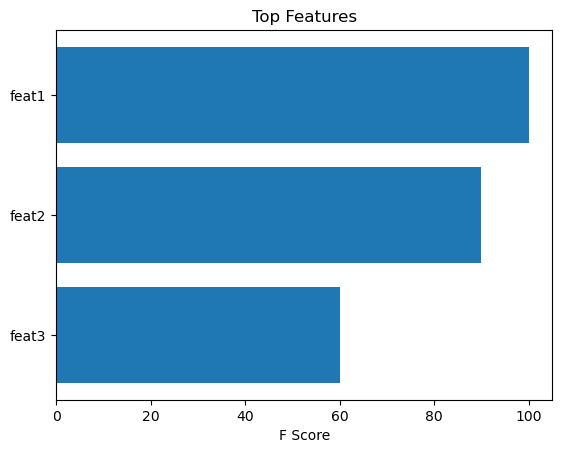

In [78]:
# TEST: graph_xgboost
cols = ['feat1', 'feat2', 'feat3']
importance = [100, 90, 60]
graph_xgb(cols, importance)

Train Accuracy: 100.00%
Test Accuracy: 94.50%


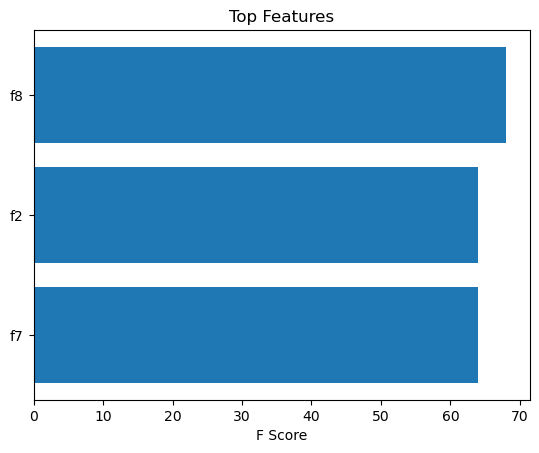

Train ROC: 1.0 
 The model perfectly classifies all positive and negative examples. It may be overfit
Test ROC: 0.9454008607746972 
 The model has decent/good performance. The higher the AUC the better.


In [80]:
# TEST: build_xgb

# 1. Generate a synthetic classification dataset 
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_classes=2, random_state=13)

# 2. Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model, top_feat_list = build_xgb(x_train, y_train, x_test, y_test, n_feat=3, classify=True, roc=True)